In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import ray
import ray.rllib.agents.ppo as ppo
import ray.rllib.agents.ddpg as ddpg
import ray.rllib.agents.ddpg.td3 as td3

import ray.rllib.agents.sac as sac
import seagul.envs
import numpy as np
from numpy import pi
import gym
from mpl_toolkits.mplot3d import Axes3D
#from simple_pid import PID

import dill
import pickle
import gym
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf
import itertools
%matplotlib inline

import pandas as pd

In [2]:
home_path = '/home/sgillen/work/'

checkpoint_path = home_path + \
"seagul/seagul/notebooks/lorenz/data/tune/custom_reward/PPO/PPO_linear_z-v0_21a281cc_2020-02-12_21-31-48o6kp5nwx/checkpoint_455/checkpoint-455"

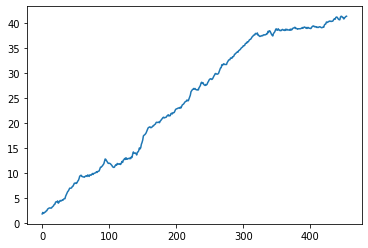

In [3]:
# Some delightfully ugly python to infer where everything else is...
config_path =  '/'.join(checkpoint_path.split('/')[:-2]) + '/params.pkl'
config = dill.load(open(config_path, 'rb'))
env_name = config['env']

csv_path = '/'.join(checkpoint_path.split('/')[:-2]) + '/progress.csv'
df = pd.read_csv(csv_path)
plt.plot(df['episode_reward_mean'])

In [4]:
def do_rollout(init_point):
    env = gym.make(env_name, **config['env_config'])
    obs = env.reset(init_point)

    action_hist = []
    m_act_hist = []
    obs_hist = []
    reward_hist = []

    done = False

    while not done:
        actions, _ , out_dict = trainer.compute_action(obs,full_fetch=True)
        obs, reward, done, _ = env.step(np.asarray(actions))

        action_hist.append(np.copy(actions))
        obs_hist.append(np.copy(obs))
        reward_hist.append(np.copy(reward))


    action_hist = np.stack(action_hist)
    obs_hist = np.stack(obs_hist)
    reward_hist = np.stack(reward_hist)
    
    return obs_hist, action_hist, reward_hist


ray.shutdown()
ray.init()

trainer = ppo.PPOTrainer(config)#, config['env_name'])
#trainer = td3.TD3Trainer(config)
#trainer = ddpg.DDPGTrainer(config)
#trainer = sac.SACTrainer(config)

trainer.restore(checkpoint_path)

2020-02-14 13:22:06,688	WARNING services.py:592 -- setpgrp failed, processes may not be cleaned up properly: [Errno 1] Operation not permitted.
2020-02-14 13:22:06,689	INFO resource_spec.py:212 -- Starting Ray with 13.72 GiB memory available for workers and up to 6.87 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-02-14 13:22:07,008	INFO services.py:1093 -- View the Ray dashboard at localhost:8265
2020-02-14 13:22:07,280	INFO trainer.py:370 -- Tip: set 'eager': true or the --eager flag to enable TensorFlow eager execution
2020-02-14 13:22:07,301	INFO trainer.py:517 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
2020-02-14 13:22:11,532	WARNING trainable.py:210 -- Getting current IP.
2020-02-14 13:22:11,533	INFO trainable.py:416 -- Restored on 128.111.57.96 from checkpoint: /home/sgillen/work/seagul/seagul/notebooks/lorenz/data/tune/custom_reward/PPO/PPO_li

# Rollouts

45.0


Text(0.5, 1.0, 'Actions')

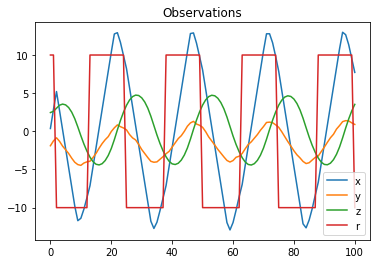

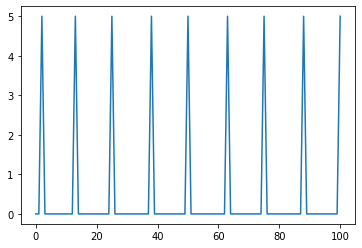

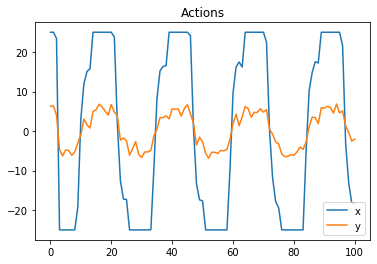

In [6]:
obs_hist, action_hist, reward_hist = do_rollout(init_point = np.random.uniform(-10,10,3))
print(sum(reward_hist))

plt.plot(obs_hist)
plt.title('Observations')
plt.legend(['x', 'y', 'z', 'r'])

plt.figure()
plt.plot(reward_hist)

plt.figure()
plt.plot(action_hist)
plt.legend(['x', 'y'])
plt.title('Actions')

Text(0.5, 0.92, 'phase diagram')

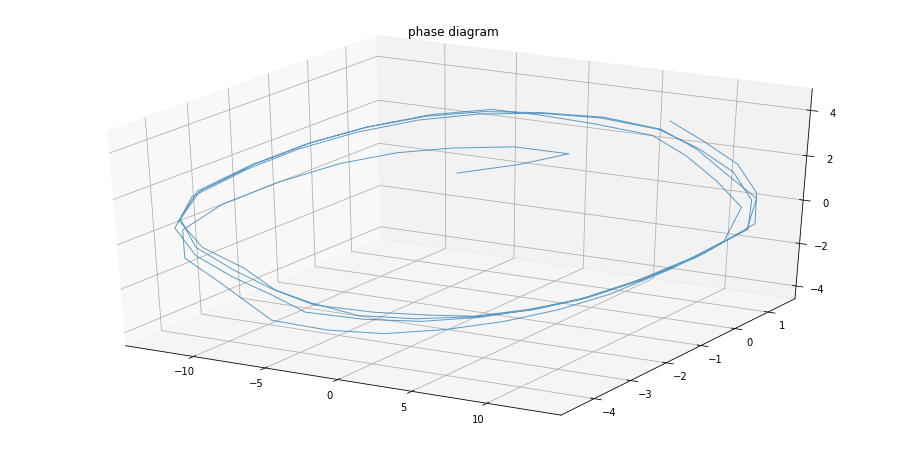

In [7]:
obs_arr = np.stack(obs_hist)

x = obs_arr[:,0]; y = obs_arr[:,1]; z = obs_arr[:,2]

fig = plt.figure(figsize=(16,8))
ax = fig.gca(projection='3d')
ax.plot(x,y,z, alpha=0.7, linewidth=1)
ax.set_title('phase diagram')

# Local Point Analysis

In [95]:
num_steps = config['env_config']['num_steps']
config['env_config']['num_steps'] = 5000
obs_hist, _ , _ = do_rollout(np.array([0,0,0]))
limit_set = obs_hist[4900:,:]
config['env_config']['num_steps'] = num_steps

In [96]:
seed_point = np.array(obs_hist[-1,:3])
dx = dy = dz = 1e-6

deltas = itertools.product([-dx, dx, 0], [-dy, dy, 0], [-dz, dz, 0])
deltas = np.array(list(deltas))

init_points = seed_point + deltas

final_points = np.zeros_like(init_points)
min_points = np.zeros_like(init_points)
trajs = np.zeros((init_points.shape[0], config['env_config']['num_steps']+1, init_points.shape[1]))

trainer.get_policy().cur_noise_scale = 0.0

for i, init_point in enumerate(init_points):
    obs_hist, act_hist, rew_hist = do_rollout(init_point)
    trajs[i,:] = obs_hist[:,:3]

In [97]:
num_trajs = trajs.shape[0]

min_x = np.zeros((num_trajs, num_steps))
min_y = np.zeros((num_trajs, num_steps))
min_z = np.zeros((num_trajs, num_steps))
min_d = np.zeros((num_trajs, num_steps))
min_d = np.zeros((num_trajs, num_steps))
min_dxz = np.zeros((num_trajs, num_steps))

for i in range(trajs.shape[0]):
    for t in range(num_steps):
        min_x[i,t] = np.min(np.linalg.norm((trajs[i,t,0] - limit_set[:,0]).reshape(1,-1),axis=0))
        min_y[i,t] = np.min(np.linalg.norm((trajs[i,t,1] - limit_set[:,1]).reshape(1,-1),axis=0))
        min_z[i,t] = np.min(np.linalg.norm((trajs[i,t,2] - limit_set[:,2]).reshape(1,-1),axis=0))
        min_d[i,t] = np.min(np.linalg.norm(trajs[i,t,:] - limit_set[:,:3], axis=1))
        min_dxz[i,t] = np.min(np.linalg.norm(trajs[i,t,0::2] - limit_set[:,0::2], axis=1))

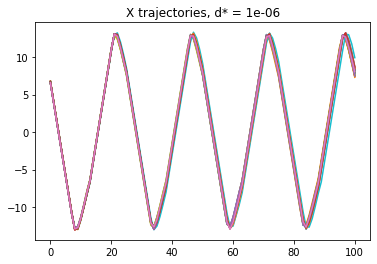

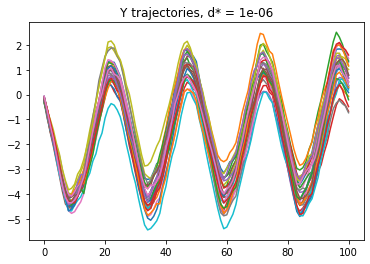

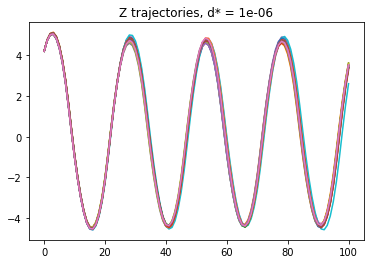

In [98]:
for i,_ in enumerate(trajs[:,0,0]):
    plt.plot(trajs[i,:,0])
    plt.title("X trajectories, d* = " + str(dx))
    
plt.figure()
for i,_ in enumerate(trajs[:,0,0]):
    plt.plot(trajs[i,:,1])
    plt.title("Y trajectories, d* = " + str(dy))

plt.figure()
for i,_ in enumerate(trajs[:,0,0]):
    plt.plot(trajs[i,:,2])
    plt.title("Z trajectories, d* = " + str(dz))

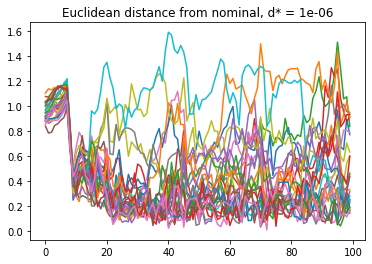

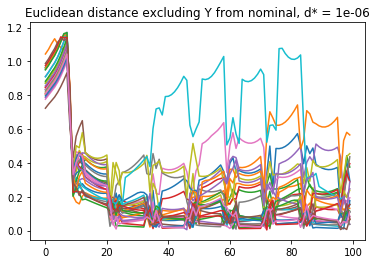

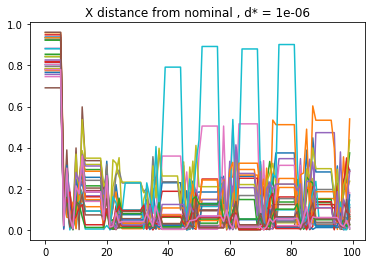

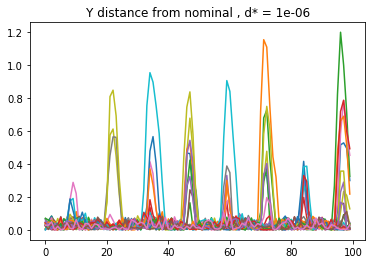

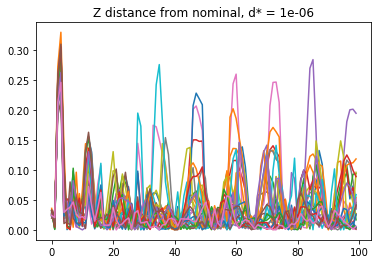

In [99]:
for i,_ in enumerate(trajs[:,0,0]):
    plt.plot(min_d[i,:])
    plt.title("Euclidean distance from nominal, d* = " + str(dx))

plt.figure()
for i,_ in enumerate(trajs[:,0,0]):
    plt.plot(min_dxz[i,:])
    plt.title("Euclidean distance excluding Y from nominal, d* = " + str(dx))
    
plt.figure()    
for i,_ in enumerate(trajs[:,0,0]):
    plt.plot(min_x[i,:])
    plt.title("X distance from nominal , d* = " + str(dx))

plt.figure()
for i,_ in enumerate(trajs[:,0,0]):
    plt.plot(min_y[i,:])
    plt.title("Y distance from nominal , d* = " + str(dx))

plt.figure()
for i,_ in enumerate(trajs[:,0,0]):
    plt.plot(min_z[i,:])
    plt.title("Z distance from nominal, d* = " + str(dx))

# Global point analysis

In [100]:
num_points = int(1e3)
config["env_config"]["num_steps"] = 1000

init_points = np.random.uniform(low = np.array([-10,-10,-10]), high = np.array([10, 10, 10]), size=(num_points,3))
final_points = np.zeros_like(init_points)
trajs = np.zeros((init_points.shape[0], config["env_config"]["num_steps"]+1, init_points.shape[1]))

for i, init_point in enumerate(init_points):
    obs_hist, act_hist, rew_hist = do_rollout(init_point)
    trajs[i,:] = obs_hist[:,:3]
    final_points[i,:] = obs_hist[-1,:3]

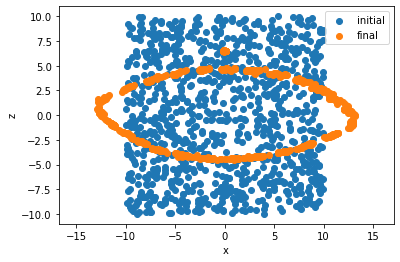

In [101]:
plt.scatter(init_points[:,0], init_points[:,2])
plt.scatter(final_points[:,0], final_points[:,2])
plt.axis('equal')
plt.xlabel('x')
plt.ylabel('z')
plt.legend(['initial', 'final'])

# Network output analysis

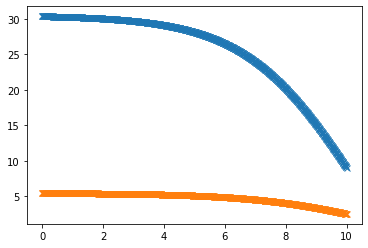

In [102]:
num_points = 1000

obs = np.array([0.0,0.0,0.0,10.0])

ys  = np.linspace(-10,10,num_points)
xs  = np.linspace(0,10,num_points)

action_arr = np.zeros((num_points, 2))
var = np.zeros((num_points,2))
logp = np.zeros((num_points,1))
vf_preds = np.zeros((num_points,1))

for i,xy in enumerate(zip(xs,ys)):
    x = xy[0]; y = xy[1]
    
    obs[0] = x; #obs[1] = y
    
    sampled_action, _ , out_dict = trainer.compute_action(obs,full_fetch=True)
    actions = out_dict['behaviour_logits'][0:2]
    var[i] = out_dict['behaviour_logits'][2:]
    logp[i] = out_dict['action_logp']
    vf_preds[i] = out_dict['vf_preds']


    action_arr[i] = actions
    
    
plt.plot(xs, action_arr[:,0], 'x')
plt.plot(xs, action_arr[:,1], 'x')

# Meshing dimensionality analysis

In [8]:
num_steps = config['env_config']['num_steps']
config['env_config']['num_steps'] = 5000
obs_hist, _ , _ = do_rollout(np.array([0,0,0]))
limit_set = obs_hist[4900:,:]
config['env_config']['num_steps'] = num_steps

In [78]:
def removearray(L,arr):
    ind = 0
    size = len(L)
    while ind != size and not np.array_equal(L[ind],arr):
        ind += 1
    if ind != size:
        L.pop(ind)
    else:
        raise ValueError('array not found in list.')

d_min = 1e-8; d_max = 25
d_vals = np.linspace(d_min, d_max, 1000)
mesh_sizes = []
        
for d in d_vals:
    orig = []
    mesh = []

    for point in limit_set[:,:3]:
        orig.append(point)

    while True:
        sample = random.sample(orig,1)[0]
        removearray(orig, sample)
        mesh.append(sample)

        for item in orig:
            if(np.linalg.norm(sample - item) < d):
                removearray(orig, item)

        if len(orig) == 0:
            break
            
    mesh_sizes.append(len(mesh))

Text(0, 0.5, 'log(Points in mesh)')

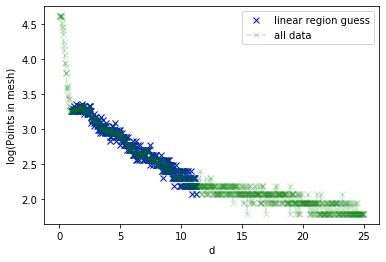

In [88]:
import scipy.optimize as opt

lin_begin = 40; lin_end = 450
xdata = np.array(d_vals[lin_begin:lin_end])
ydata = np.array(np.log(mesh_sizes[lin_begin:lin_end]))

plt.plot(xdata, ydata, 'bx')
plt.plot(d_vals, np.log(mesh_sizes), 'gx--', alpha=.2)
plt.legend(['linear region guess', 'all data'])
plt.xlabel('d')
plt.ylabel('log(Points in mesh)')

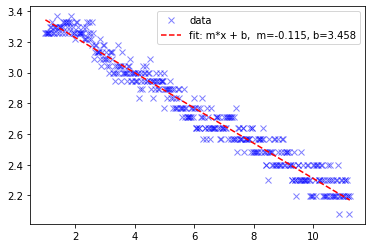

In [94]:
def f(x,m,b):
    return m*x + b

popt, pcov = opt.curve_fit(f, xdata, ydata)

plt.plot(xdata, ydata, 'bx', alpha=.5)
plt.plot(xdata, f(xdata, *popt),'r--')
plt.legend(['data', 'fit: m*x + b,  m=%5.3f, b=%5.3f' % tuple(popt)])